In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1182.49it/s]


In [24]:
device = "cpu"
block_size = 100

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long).to(device)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - 500))
test = data.Subset(dataset, range(len(dataset) - 500, len(dataset)))

In [25]:
# inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
class MinGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, dropout):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[DecoderLayer(embed_dim, dropout) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, top_k=10):
        for _ in range(max_new_tokens):
            out = self(input_ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            input_ids = torch.cat((input_ids, step_res), dim=1)

        return input_ids

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTFull(embed_dim, dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size)).to(bool).to(device))

    def forward(self, x):
        B, T, _ = x.shape
        x = self.ln1(x)
        x = x + self.attn(x, self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# https://arxiv.org/pdf/2105.14103.pdf
# I am not 100% sure this is correct but it seems to work :shrug:
class AFTFull(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.wbias = nn.Parameter(torch.ones(block_size, block_size), requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)

        exp_w = self.wbias[:T,:T].masked_fill(mask[:T, :T], -float("Inf")).unsqueeze(0).exp()
        exp_k = k.exp()

        weighted_avg = exp_w @ (exp_k * v) / (exp_w @ exp_k)
        Yt = F.sigmoid(q) * weighted_avg

        return self.drop(self.proj(Yt))


class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.004):
        super().__init__()
        self.lr = lr
        self.model = MinGPT(vocab_size, embed_dim=192, num_layers=3, dropout=0.1)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=100, num_workers=0, sampler=data.RandomSampler(train, False, 5_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=16, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            x = torch.tensor([dataset.stoi[s] for s in "And now "], dtype=torch.long)[None,...].to(device)
            y = self.model.generate(x, 64)[0]
            print("".join([dataset.itos[int(i)] for i in y]))

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

model = Model(len(dataset.vocab))
trainer = pl.Trainer(gradient_clip_val=1.0, max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else "cpu")
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | MinGPT | 1.4 M 
---------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.560     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 33.86it/s]And now -k
B&Y,upRo&tjRQzvYFk
R.
AEVpAz'KCi3vLQqKCrVUDya.VGgAl yIhduObgH
                                                                           

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 82/82 [00:19<00:00,  4.11it/s, loss=2.32, v_num=45, test_loss=2.380]And now sotild sit aged.


FrRIULOHARETH:
My. thay teend thet bon my thi
Epoch 2: 100%|██████████| 82/82 [00:19<00:00,  4.20it/s, loss=2.17, v_num=45, test_loss=2.230]And now a this ther,
Thirg heitelll, shou that mo thers.

FORIER:
Thelll
Epoch 3: 100%|██████████| 82/82 [00:18<00:00,  4.34it/s, loss=1.95, v_num=45, test_loss=2.080]And now that sto thou dard tone?
Muld as haven anesur'd the father our h
Epoch 4: 100%|██████████| 82/82 [00:18<00:00,  4.37it/s, loss=1.82, v_num=45, test_loss=1.960]And now bees fore the hear me secure.

DUKE OF YORK:
With hilhave deg, h
Epoch 5: 100%|██████████| 82/82 [00:19<00:00,  4.26it/s, loss=1.72, v_num=45, test_loss=1.850]And now them.

LUCENTIO:
Where any, the fart you.

Rurse:
I be you men b
Epoch 6: 100%|██████████| 82/82 [00:18<00:00,  4.32it/s, loss=1.66, v_num=45, test_loss=1.730]And now my from thee, the words.
Sincess the worm hold that she truncil

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 82/82 [00:20<00:00,  3.94it/s, loss=1.38, v_num=45, test_loss=1.360]


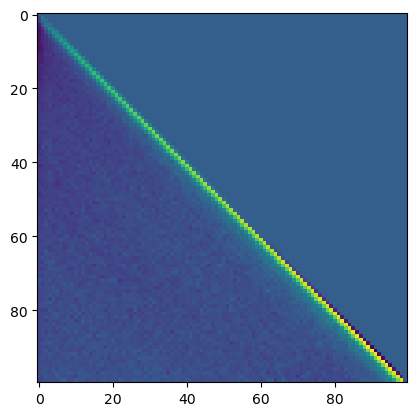

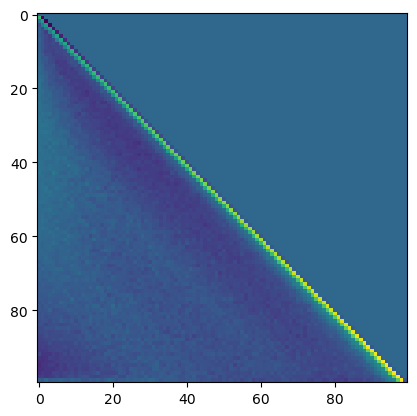

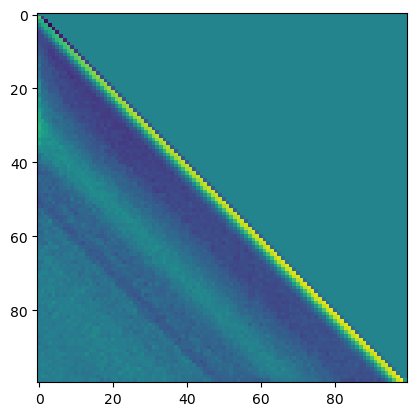

In [26]:
from matplotlib import pyplot as plt
for b in model.model.transformer[2]:
    plt.figure()
    plt.imshow(b.attn.wbias.detach().numpy())

In [27]:
y = model.to(device).model.generate(torch.tensor([dataset.stoi[s] for s in "O God, O God!"]).unsqueeze(0).to(device), 650)
print("".join([dataset.itos[int(i)] for i in y[0]]))

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


O God, O God! and merry thy sheel she
As I shall die by hid my worn so must along.

DUKE VINCENTIO:
He cannot well be thou bonded to be
I think you, you are your prison another,
Wheeen yet, what should were you must say
To being and leavin done is a maid
To me of a childrens themal freeles timortalty;
And beat he may studden steel.

HASTINGS:
Whipt here's he were not of the sevells and so fleeps
To have have been his worder, than with
I peering are of my service, we belliever
To here to beg with the trose with him fright,
Are you may be sentencing her bound: thee slain
That should not bawddres, withdraw of what here,
I wouldst thou makest have the cheers.
